In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import tarfile
import urllib
import pets
from matplotlib import pyplot as plt

In [2]:
#making new directory for the data
data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [5]:
pets.download_and_extract('data', '.')

In [3]:
class_to_index = {'cat':0, 'dog':1}
index_to_class = {0:'cat', 1:'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training Examples:', count_train)
print('Testing Examples:', count_test)

Training Examples: 3680
Testing Examples: 3669


In [4]:
image_dir = 'data/images/'

def get_random_batch(annot, batch_size=4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    
    indices = np.random.choice(range(total_examples), batch_size)
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    images = []
    
    for i, index in enumerate(indices):
        image_path = os.path.join(image_dir, all_keys[index])
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128,128))
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[index]]]
        images.append(image)
        
    return x, y, images

Displaying first 8 examples..


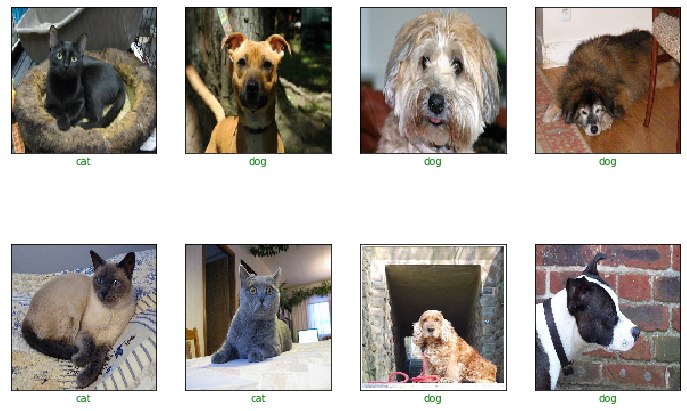

In [5]:
x, y, images = get_random_batch(train_annot, batch_size=8)
pets.display_examples(x, y, y, images, index_to_class).show()

In [6]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False, pooling='avg', weights='imagenet', input_shape=(128,128,3))
mnet.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [7]:
def create_model():
    model = tf.keras.models.Sequential([
        mnet,
        tf.keras.layers.Dropout(0.45),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=(['accuracy']))
    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size)
        yield (x,y)

In [9]:
batch_size = 32
steps_per_epoch = int(count_train/batch_size)
validation_steps = int(count_test/batch_size)


In [10]:
_ = model.fit_generator(
    data_generator(batch_size, train_annot),
    validation_data = data_generator(batch_size, test_annot),
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs = 1
)

Instructions for updating:
Please use Model.fit, which supports generators.
115/115 [==============================] - 234s 2s/step - loss: 0.2487 - accuracy: 0.9054 - val_loss: 0.0964 - val_accuracy: 0.9723


In [11]:
x, y, images = get_random_batch(test_annot, batch_size = 8)
preds = model.predict(x)

Displaying first 8 examples..


<module 'matplotlib.pyplot' from 'C:\\Users\\tanmaysheoran\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

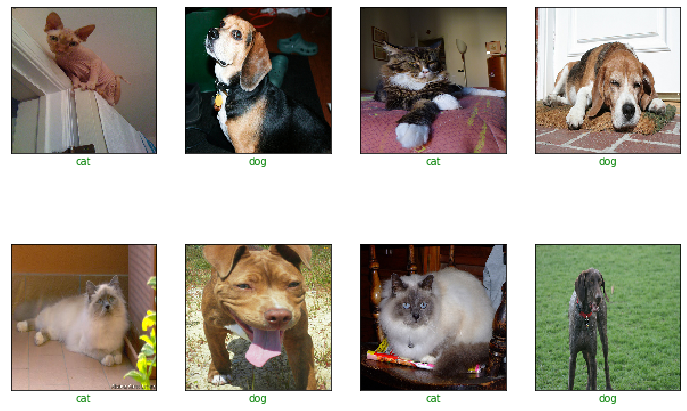

In [12]:
pets.display_examples(x, y, preds, images, index_to_class)